In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [95]:
# function for calculating the correlation between two variables
def get_corr(a, b, pr=3):
    corr = pearsonr(a, b)[0]
    corr = np.round(corr, pr)
    return str(corr)


# function for printing the equation created by the linear regression model
def print_equation(model, sf=4, pr=3):
    coefs = np.round(model.coef_, pr)
    intercept = np.round(model.intercept_, pr)
    
    # string for the model equation
    equation = 'Model equation:\nN100 ='
    
    # adding the coefficients one after another
    for i in range(len(coefs)):
        if coefs[i] < 0:
            equation += ' - '
        elif i == 0:
            equation += ' '
        else:
            equation += ' + '
        
        equation += str(np.abs(coefs[i]))
        equation += '*' + predictors[i]  # variable_dict[predictors[i]]
    
    # adding the intercept
    if intercept < 0:
        equation += ' - '
    else:
        equation += ' + '
        
    equation += str(np.abs(intercept)) + '\n'               
    print(equation)

    
# function for calculating the R2 score and RMSE
def eval_model(predictions, model):
    r2 = r2_score(y_test, predictions)
    print('R2 score on test set:\n%.3f\n' % r2)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print('RMSE on test set:\n%.3f\n' % rmse)
    
    return (r2, rmse)

    
# function for plotting the log-transformed observed and predicted n100 concentrations against each other
def log_log_eval(log_predictions):
    valid_indices = np.isfinite(log_predictions)
    
    plt.figure(figsize=(5, 5))
    plt.title('Observed vs. Predicted N100 Concentration (Log-Transformed)')
    
    axis_min, axis_max = 0, 10
    
    # plotting the line of perfect fit
    plt.plot(list(range(axis_min, axis_max+1)), list(range(axis_min, axis_max+1)), c='black', alpha=0.25)
        
    # plotting the data
    plt.scatter(log_y_test[valid_indices], log_predictions[valid_indices], s=2, alpha=0.5)
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    print('Correlation between observed and predicted log-transformed N100 concentration:\n'+
          get_corr(log_y_test[valid_indices], log_predictions[valid_indices])+'\n')

    
# function for plotting the observed and predicted n100 concentrations against each other
def corr_eval(predictions):
    plt.figure(figsize=(5, 5))
    plt.title('Observed vs. Predicted N100 Concentration')
    
    axis_min, axis_max = 0, int(y_test.max())
    
    # plotting the line of perfect fit
    plt.plot(list(range(axis_min, axis_max+1)), list(range(axis_min, axis_max+1)), c='black', alpha=0.25)
        
    # plotting the data
    plt.scatter(y_test, predictions, s=2, alpha=0.5)
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    print('Correlation between observed and predicted N100 concentration:\n'+get_corr(y_test, predictions)+'\n')


# function for plotting the predicted and observed n100 concentrations
def plot_results(name, predictions):
    plt.figure(figsize=(15,5))
    plt.title('Performance of ' + name + ' Model - Test Set')
    
    plt.plot(np.array(y_test), label='Observed')
    plt.plot(predictions, label='Predicted')
    
    xticks_mask = list(range(0, dates_test.shape[0], int(dates_test.shape[0] / 8)))
    xticks = dates_test.iloc[xticks_mask]
    plt.xticks(xticks_mask, xticks)
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('N100 concentration')
    
def plot_all_results(name, predictions, data):
    plt.figure(figsize=(15, 5))
    plt.title('Performance of ' + name + ' Model - Whole Dataset')
    
    plt.plot(data.n100, label='Observed')
    plt.plot(predictions, label='Predicted', alpha=0.75)
    plt.xlabel('Timestep')
    plt.ylabel('N100 Concentration')
    plt.legend()

    plt.figure(figsize=(15, 5))
    plt.title('Residual of Predictions for ' + name + ' Model - Whole Dataset')
    
    plt.plot(np.abs(data.n100 - predictions), c='green', alpha=0.75)
    plt.hlines([0, 2500, 5000], 0, len(predictions), linestyles = 'dotted')
    plt.xlabel('Timestep')
    plt.ylabel('N100 Concentration')

In [63]:
cities = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
          'HAD', 'HEL', 'HPB', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 'MLP', 'MUK', 
          'NAN', 'NEU', 'POV', 'SAO', 'SCH', 'SGP', 'UAE', 'VAR', 'VIE', 'WAL', 
          'ZOT']

variables = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 'aermr07', 
             'aermr08', 'aermr09', 'aermr10', 'co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 
             'so2', 'd2m', 't2m', 'crwc', 'blh', 'rh', 'doy_sin', 'doy_cos', 'latitude', 
             'longitude_sin', 'longitude_cos']

dont_transform = ['d2m', 't2m', 'blh', 'rh', 'doy_sin', 'doy_cos', 'latitude', 'longitude_sin', 'longitude_cos']

predictors = []
for v in variables:    
    if v in dont_transform:
        predictors.append(v)
    else:
        predictors.append(v+'_log')

In [64]:
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])

for v in variables:
    if v not in dont_transform:
        transformed = data[v]
        transformed = transformed.where(transformed != transformed.min(), transformed.nlargest(2).iloc[-1])
        data[v+'_log'] = np.log(transformed)
        
data.head()

,id,station,date,doy_sin,doy_cos,latitude,longitude_sin,longitude_cos,n100,aermr01,...,aermr09_log,aermr10_log,co_log,c5h8_log,c10h16_log,nh3_log,no_log,no2_log,so2_log,crwc_log
0,ABZ-2012-01-26,ABZ,2012-01-26,0.431673,0.902030,0.561889,0.438057,0.898947,2708.085714,6.752697e-12,...,-22.383946,-21.309149,-14.888857,-24.715712,-22.277308,-20.891909,-18.156078,-17.697916,-18.856889,-9.139102
1,ABZ-2012-01-27,ABZ,2012-01-27,0.447094,0.894487,0.561889,0.438057,0.898947,2489.175000,4.223335e-12,...,-22.018130,-21.181645,-14.786466,-24.526129,-22.109902,-20.714570,-18.022533,-17.632291,-18.761336,-9.139102
2,ABZ-2012-01-28,ABZ,2012-01-28,0.462383,0.886680,0.561889,0.438057,0.898947,3484.229167,3.553853e-12,...,-21.523018,-20.943542,-14.472229,-24.080899,-21.518834,-20.381543,-17.223582,-17.785600,-18.708921,-9.139102
3,ABZ-2012-01-29,ABZ,2012-01-29,0.477536,0.878612,0.561889,0.438057,0.898947,2977.512500,8.665312e-12,...,-21.433621,-21.326093,-14.977114,-25.068593,-22.885339,-20.340459,-19.236020,-17.969860,-19.128033,-9.139102
4,ABZ-2012-01-30,ABZ,2012-01-30,0.492548,0.870285,0.561889,0.438057,0.898947,2702.463636,1.436837e-11,...,-21.482813,-21.669206,-15.236442,-25.461374,-23.836271,-20.333199,-20.702253,-18.124264,-19.070916,-9.139102


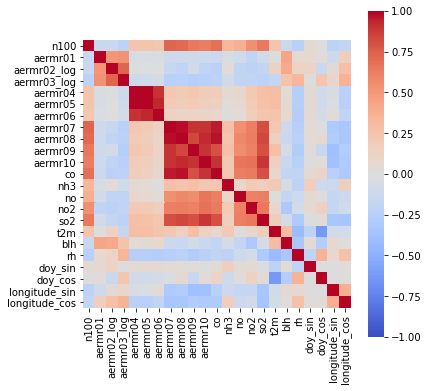

In [156]:
predictors = ['aermr01', 'aermr02_log', 'aermr03_log', 'aermr04', 'aermr05', 'aermr06', 
              'aermr07', 'aermr08', 'aermr09', 'aermr10', 'co', 'nh3', 'no', 'no2', 'so2', 
              't2m', 'blh', 'rh', 'doy_sin', 'doy_cos', 'longitude_sin', 'longitude_cos']

plt.figure(figsize=(6,6))
sns.heatmap(data[['n100'] + predictors].corr(), 
            xticklabels=['n100'] + predictors, yticklabels=['n100'] + predictors, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1);

In [157]:
# splitting the dataset into traning (75%) and testing (25%) sets
indices = np.arange(len(data))
np.random.seed(42)
np.random.shuffle(indices)
split = int(len(indices) * 0.75)
train_indices = indices[:split]
test_indices = indices[split:]

# predictor variables
X_train = np.take(data[predictors], train_indices, 0)
X_test = np.take(data[predictors], test_indices, 0)

# n100 concentration
y_train = np.take(data.n100, train_indices, 0)
y_test = np.take(data.n100, test_indices, 0)
log_y_test = np.take(np.log(data.n100.where(data.n100 != 0, 0.1)), test_indices, 0)

print('Train set shapes:', X_train.shape, 'and', y_train.shape)
print('Test set shapes:', X_test.shape, 'and', y_test.shape)

Train set shapes: (36183, 22) and (36183,)
Test set shapes: (12061, 22) and (12061,)


Model equation:
N100 = - 488114412027.995*aermr01 - 40.47*aermr02_log - 4.018*aermr03_log + 148807293486.52*aermr04 - 160754201567.713*aermr05 + 68797756387.962*aermr06 - 6617138157.649*aermr07 + 142450051931.555*aermr08 + 1413716326138.428*aermr09 - 1689913314909.243*aermr10 - 2251554212.21*co + 67769889744.945*nh3 + 53348523.779*no + 19220864596.478*no2 + 30607419201.725*so2 + 16.796*t2m - 0.186*blh - 3.094*rh + 45.823*doy_sin + 233.134*doy_cos - 258.663*longitude_sin + 298.165*longitude_cos - 4785.062

Correlation between observed and predicted N100 concentration:
0.81

Correlation between observed and predicted log-transformed N100 concentration:
0.61

R2 score on test set:
0.656

RMSE on test set:
908.677



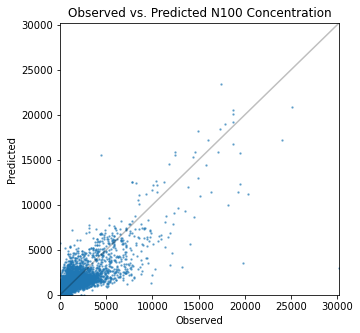

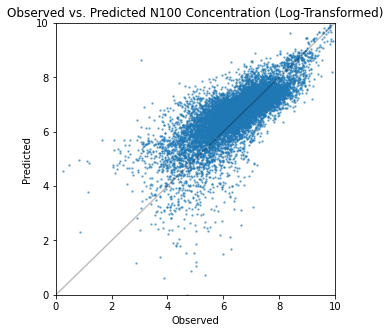

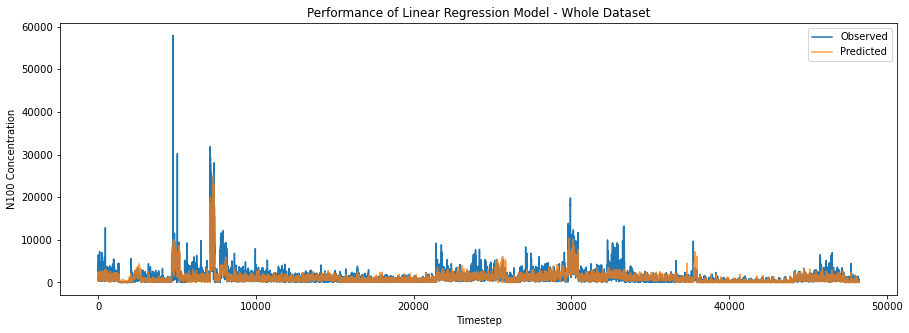

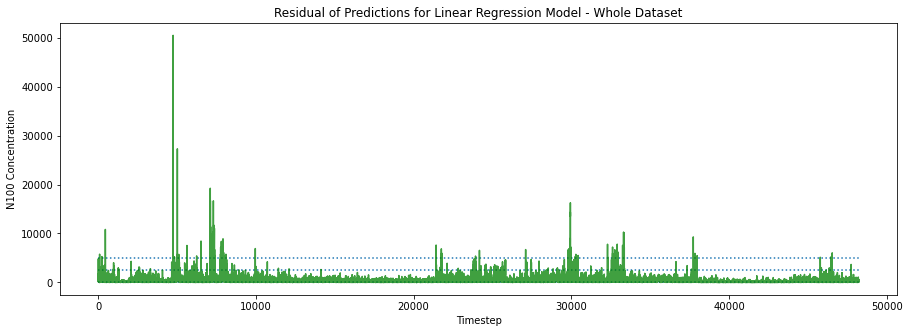

In [158]:
# fitting the linear regression model
model = LinearRegression().fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)

# removing predictions that are negative
predictions[predictions <= 0] = 0.1
log_predictions = np.log(predictions)

# printing the model evaluation
print_equation(model)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions)
log_log_eval(log_predictions)

# evaluating the model performance
eval_model(predictions, model)

# making predictions for the whole dataset
predictions_all = model.predict(np.array(data[predictors]))
predictions_all[predictions_all <= 0] = 0.1
        
# plotting the observed and predicted n100 concentrations against time
plot_all_results('Linear Regression', predictions_all, data)

Correlation between observed and predicted N100 concentration:
0.904

Correlation between observed and predicted log-transformed N100 concentration:
0.899

R2 score on test set:
0.817

RMSE on test set:
663.345



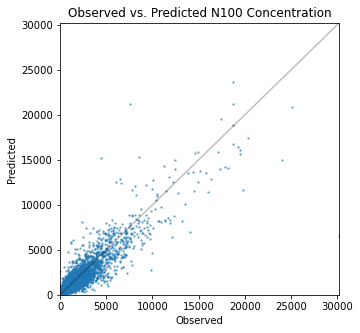

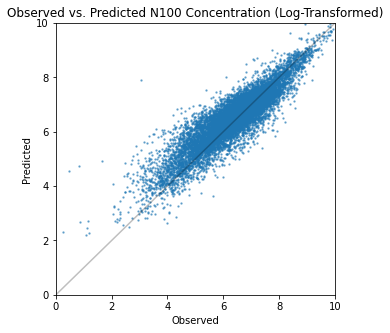

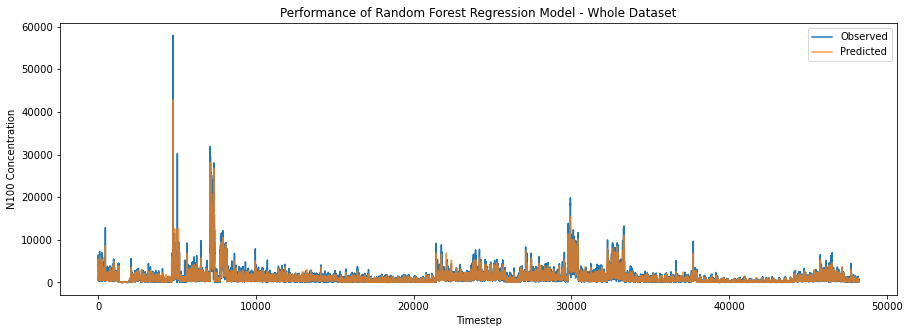

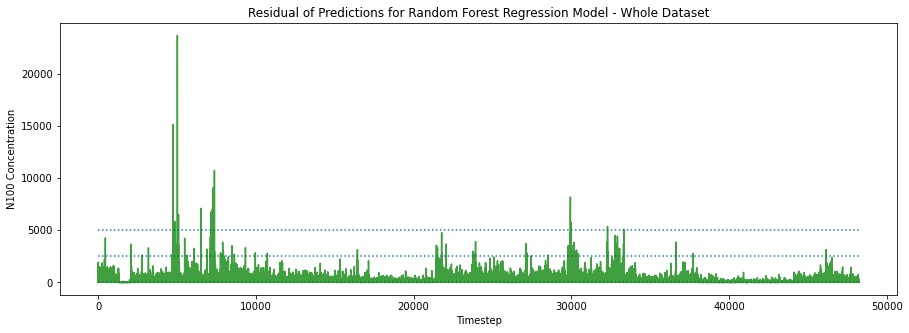

In [159]:
# fitting the linear regression model
model = RandomForestRegressor(max_depth=20).fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)

# removing predictions that are negative
predictions[predictions <= 0] = 0.1
log_predictions = np.log(predictions)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions)
log_log_eval(log_predictions)

# evaluating the model performance
eval_model(predictions, model)

# making predictions for the whole dataset
predictions_all = model.predict(np.array(data[predictors]))
predictions_all[predictions_all <= 0] = 0.1
        
# plotting the observed and predicted n100 concentrations against time
plot_all_results('Random Forest Regression', predictions_all, data)